In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'ADA'

# Create crypto df
crypto_df = f'{crypto}_df'.lower()

In [5]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
crypto_df = pd.read_csv(
    f'~/crypto-forecast/Resources/{crypto}-USD.csv',
    index_col='Date',
    parse_dates=True
).dropna()

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.025160,0.035060,0.025006,0.032053,0.032053,18716200.0
2017-11-10,0.032219,0.033348,0.026451,0.027119,0.027119,6766780.0
2017-11-11,0.026891,0.029659,0.025684,0.027437,0.027437,5532220.0
2017-11-12,0.027480,0.027952,0.022591,0.023977,0.023977,7280250.0
2017-11-13,0.024364,0.026300,0.023495,0.025808,0.025808,4419440.0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-14,0.436544,0.437814,0.426998,0.428069,0.428069,313435137.0
2024-05-15,0.428069,0.454588,0.426750,0.452988,0.452988,357450532.0
2024-05-16,0.452996,0.461976,0.449552,0.459695,0.459695,367462393.0
2024-05-17,0.459696,0.489945,0.455974,0.482000,0.482000,447612110.0
2024-05-19,0.482419,0.482419,0.481067,0.481067,0.481067,235718576.0


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

0.481067

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998242,0.997277,0.996891,0.996891,0.675729
High,0.998242,1.000000,0.996516,0.998810,0.998810,0.694695
Low,0.997277,0.996516,1.000000,0.997901,0.997901,0.656729
Close,0.996891,0.998810,0.997901,1.000000,1.000000,0.682971
Adj Close,0.996891,0.998810,0.997901,1.000000,1.000000,0.682971
Volume,0.675729,0.694695,0.656729,0.682971,0.682971,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2017-11-09,0.032053,18716200.0
2017-11-10,0.027119,6766780.0
2017-11-11,0.027437,5532220.0
2017-11-12,0.023977,7280250.0
2017-11-13,0.025808,4419440.0
...,...,...
2024-05-14,0.428069,313435137.0
2024-05-15,0.452988,357450532.0
2024-05-16,0.459695,367462393.0


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2017-12-28,0.407701,82263800.0,0.437319,0.269667,0.175326
2017-12-29,0.529299,266403008.0,0.437121,0.284319,0.185270
2017-12-30,0.639243,645155968.0,0.452430,0.301631,0.197513
2017-12-31,0.719695,305947008.0,0.476615,0.321243,0.211358
2018-01-01,0.728657,150186000.0,0.508765,0.341120,0.225452


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-05-14,0.428069,313435137.0,0.445994,0.461548,0.513488
2024-05-15,0.452988,357450532.0,0.445459,0.461288,0.509247
2024-05-16,0.459695,367462393.0,0.446000,0.461325,0.505471
2024-05-17,0.482000,447612110.0,0.450012,0.462581,0.502095
2024-05-19,0.481067,235718576.0,0.452864,0.463345,0.498429


<Axes: xlabel='Date'>

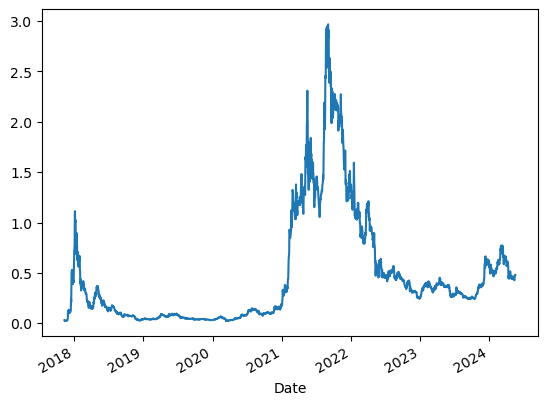

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2017-11-09,0.032053,18716200.0
1,2017-11-10,0.027119,6766780.0
2,2017-11-11,0.027437,5532220.0
3,2017-11-12,0.023977,7280250.0
4,2017-11-13,0.025808,4419440.0
...,...,...,...
2378,2024-05-14,0.428069,313435137.0
2379,2024-05-15,0.452988,357450532.0
2380,2024-05-16,0.459695,367462393.0
2381,2024-05-17,0.482000,447612110.0


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

18:49:57 - cmdstanpy - INFO - Chain [1] start processing
18:49:57 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
2468,2024-08-13
2469,2024-08-14
2470,2024-08-15
2471,2024-08-16
2472,2024-08-17


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2443,2024-07-19,0.544520,0.235661,0.647724,0.514994,0.574596,-0.101263,-0.101263,-0.101263,-0.001252,-0.001252,-0.001252,-0.100011,-0.100011,-0.100011,0.0,0.0,0.0,0.443258
2444,2024-07-20,0.544996,0.238372,0.646723,0.514727,0.575816,-0.099603,-0.099603,-0.099603,0.002454,0.002454,0.002454,-0.102057,-0.102057,-0.102057,0.0,0.0,0.0,0.445394
2445,2024-07-21,0.545472,0.245132,0.634713,0.513918,0.576575,-0.101604,-0.101604,-0.101604,0.002610,0.002610,0.002610,-0.104214,-0.104214,-0.104214,0.0,0.0,0.0,0.443868
2446,2024-07-22,0.545948,0.253850,0.639091,0.513496,0.578082,-0.106947,-0.106947,-0.106947,-0.000536,-0.000536,-0.000536,-0.106412,-0.106412,-0.106412,0.0,0.0,0.0,0.439001
2447,2024-07-23,0.546424,0.232911,0.627042,0.513013,0.580389,-0.111363,-0.111363,-0.111363,-0.002792,-0.002792,-0.002792,-0.108571,-0.108571,-0.108571,0.0,0.0,0.0,0.435061
2448,2024-07-24,0.546900,0.227408,0.640733,0.512154,0.582410,-0.110626,-0.110626,-0.110626,-0.000021,-0.000021,-0.000021,-0.110605,-0.110605,-0.110605,0.0,0.0,0.0,0.436274
2449,2024-07-25,0.547376,0.223991,0.648963,0.511947,0.584477,-0.112883,-0.112883,-0.112883,-0.000463,-0.000463,-0.000463,-0.112419,-0.112419,-0.112419,0.0,0.0,0.0,0.434493
2450,2024-07-26,0.547852,0.226193,0.655697,0.511029,0.586404,-0.115169,-0.115169,-0.115169,-0.001252,-0.001252,-0.001252,-0.113918,-0.113918,-0.113918,0.0,0.0,0.0,0.432683
2451,2024-07-27,0.548328,0.232119,0.629195,0.509846,0.587207,-0.112547,-0.112547,-0.112547,0.002454,0.002454,0.002454,-0.115001,-0.115001,-0.115001,0.0,0.0,0.0,0.435781
2452,2024-07-28,0.548804,0.229545,0.643449,0.508895,0.590209,-0.112964,-0.112964,-0.112964,0.002610,0.002610,0.002610,-0.115573,-0.115573,-0.115573,0.0,0.0,0.0,0.435840


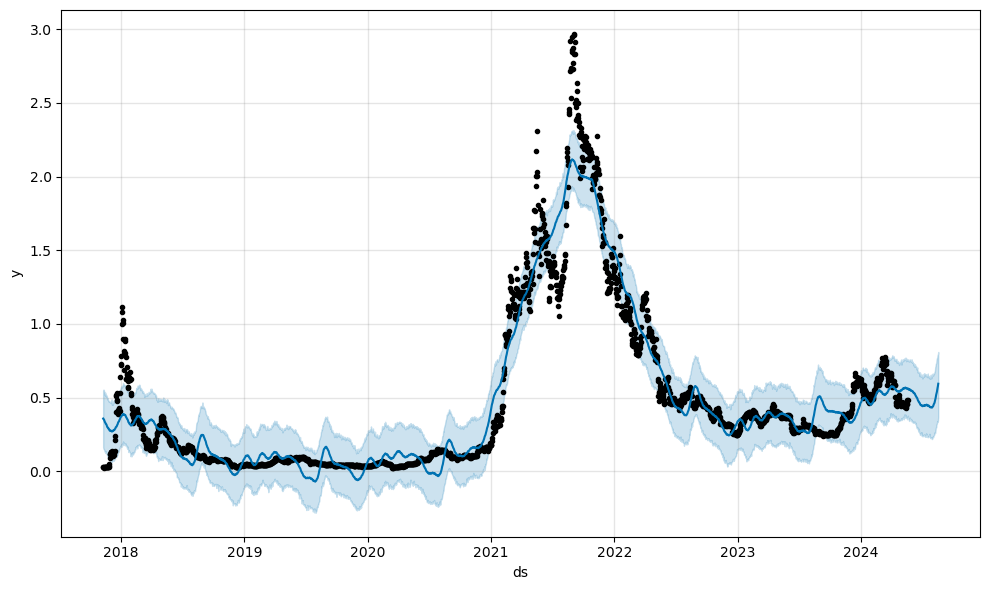

In [20]:
# Plot the Prophet predictions for the data
fig1 = crypto_model.plot(crypto_forecast)

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-05-20,0.558330,0.360004,0.759623
2024-05-21,0.554856,0.361334,0.750734
2024-05-22,0.556386,0.344355,0.744041
2024-05-23,0.554693,0.341271,0.750034
2024-05-24,0.552651,0.357890,0.752984
...,...,...,...
2024-08-13,0.538790,0.322671,0.767400
2024-08-14,0.554048,0.338858,0.770537
2024-08-15,0.566189,0.335073,0.789074


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

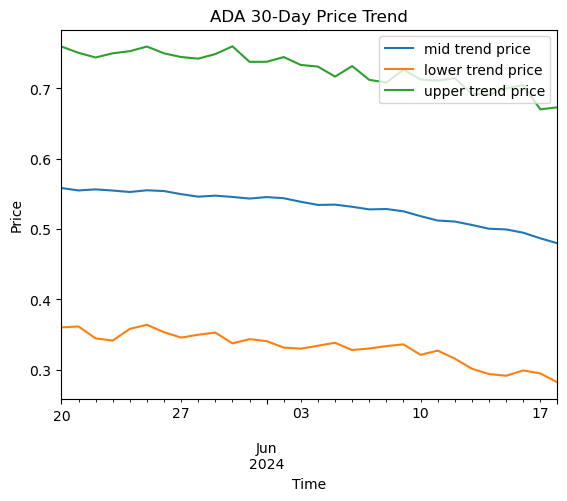

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

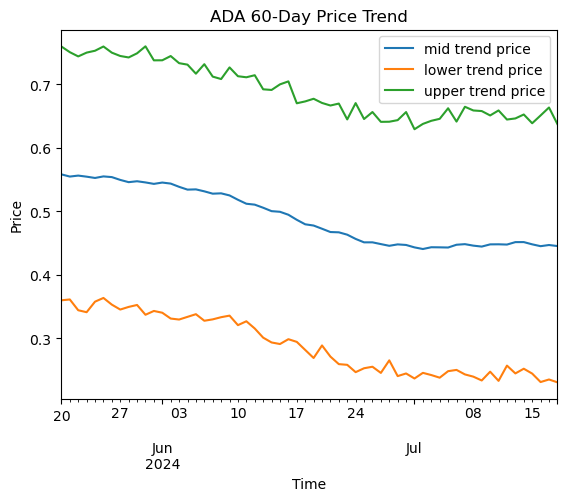

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

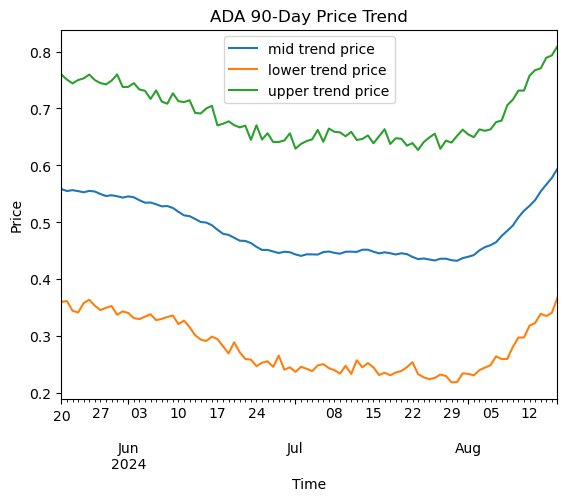

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

0.481067

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

0.5583302015223386

In [29]:
# Retrieve mid trend price in 30 days
mid_trend_price_in_30 = crypto_forecast['mid trend price'].iloc[-60]
mid_trend_price_in_30

0.4777306288257016

In [30]:
# Retrieve mid trend price in 60 days
mid_trend_price_in_60 = crypto_forecast['mid trend price'].iloc[-30]
mid_trend_price_in_60

0.44325771325449814

In [31]:
# Retrieve mid trend price in 90 days
mid_trend_price_in_90 = crypto_forecast['mid trend price'].iloc[-1]
mid_trend_price_in_90

0.593984728813497

In [32]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30.round(3)

-0.007

In [33]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60.round(3)

-0.079

In [34]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90.round(3)

0.235

In [35]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

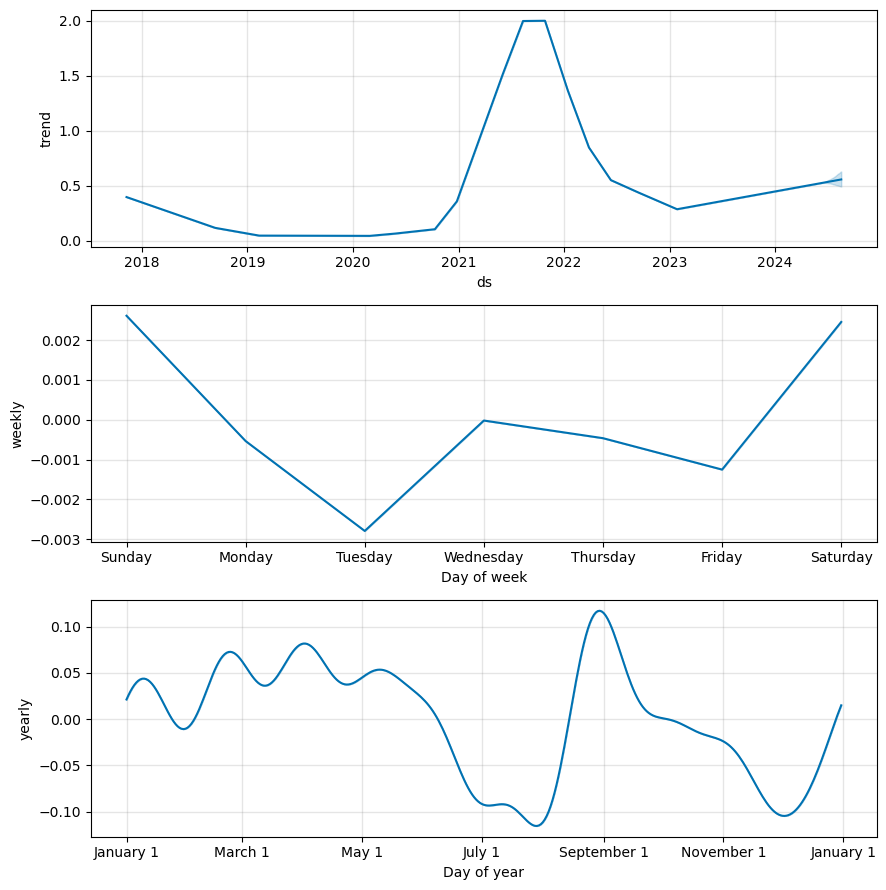

In [36]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig2 = crypto_model.plot_components(crypto_forecast)

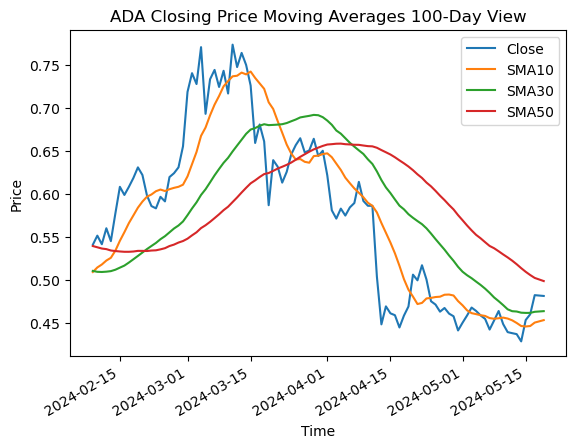

In [37]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

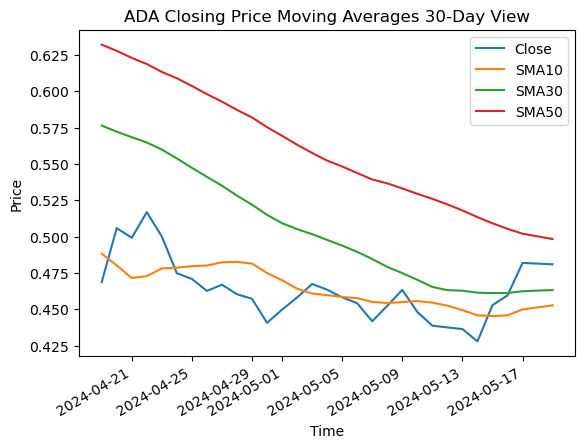

In [38]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')    
plt.show()

In [39]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-05-19
File created :  2024-05-19.csv


In [40]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [41]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.481067,-0.006935356560101691,-0.07859463805561773,0.23472349758660838

